# Data analysis

## Libraries, global parameters and data import

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import plotly.express as px
import seaborn as sns
from itertools import combinations
from math import log, isnan
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.basemap import Basemap
from operator import itemgetter
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler



sns.set(
    style="ticks",
    palette="Set2",
    rc={
        "figure.figsize": (7.1, 4.5),
        "axes.labelsize": 13.5,
        "font.size": 13.5,
        "legend.fontsize": 13.5,
        "xtick.labelsize": 13.5,
        "ytick.labelsize": 13.5,
        "text.usetex": False,
    },
)

data = pd.read_excel("datasets/Cleaned_data_zenodo.xlsx")

### Affiliations extraction

In [66]:
# Manually correct some locations that ox.geocode cannot find.
# ox.geocode generates a local cache of the locations, it seems
# that deleting the cache after some time might require editing
# this cell, because Open Street Map might introduce changes and
# make it difficult to locate some institutions.
# PLEASE REVISE THIS CELL AND MANUALLY MODIFY IF NECESSARY

In [67]:
biblio_file = open("datasets/savedrecs.txt", "r")
first_country = []
first_affiliation = []
first_affiliation_coordinates = []
doi = []
for line in biblio_file:
    if line[0:2] == "C1":
        country = line.split(",")[-1][:-2].strip()
        if country.endswith("USA"):
            country = "USA"
        first_country.append(country)
    elif line[0:2] == "C3":
        first_affiliation.append(line.split(";")[0][3:].strip())
        if first_affiliation[-1] == "Southeast University - China":
            first_affiliation_coordinates.append(
                ox.geocode("South east University, China")
            )
        elif first_affiliation[-1] == "Korea Transport Institute":
            first_affiliation_coordinates.append(
                ox.geocode("370 Sicheong-daero, Korea")
            )
        elif first_affiliation[-1] == "RLUK- Research Libraries UK":
            first_affiliation_coordinates.append(
                ox.geocode("Senate House University of London")
            )
        elif first_affiliation[-1] == "N8 Research Partnership":
            first_affiliation_coordinates.append(
                ox.geocode("Alliance Manchester Business School")
            )
        elif first_affiliation[-1] == "Tottori University":
            first_affiliation_coordinates.append(ox.geocode("国立大学法人鳥取大学 鳥取キャンパス"))
        elif first_affiliation[-1] == "Seoul National University of Science & Technology":
            first_affiliation_coordinates.append(
                ox.geocode("Seoul National University of Science")
            )
        elif first_affiliation[-1] == "Korea Institute of Civil Engineering & Building Technology (KICT)":
            first_affiliation_coordinates.append(
                ox.geocode(
                    "KICT Korean Institute of Civil Engineering and Building Technology"
                )
            )
        elif first_affiliation[-1] == "Rutgers State University New Brunswick":
            first_affiliation_coordinates.append(ox.geocode("Rutgers–New Brunswick"))
        elif first_affiliation[-1] == "Swiss Federal Institutes of Technology Domain":
            first_affiliation_coordinates.append(ox.geocode("ETH Zürich"))
        elif first_affiliation[-1] == "Osaka University":
            first_affiliation_coordinates.append(ox.geocode("Osaka University Japan"))
        elif first_affiliation[-1] == "Korea Railroad Research Institute (KRRI)":
            first_affiliation_coordinates.append(
                ox.geocode("176 Cheoldobangmulgwan-ro, Uiwang-si")
            )
        else:
            first_affiliation_coordinates.append(ox.geocode(first_affiliation[-1]))

    elif line[0:2] == "DI":
        doi.append(line[3:].strip())
first_affiliation.insert(
    doi.index("10.1007/s12469-022-00309-0"), "Ben-Gurion University of the Negev"
)
first_affiliation_coordinates.insert(
    doi.index("10.1007/s12469-022-00309-0"),
    ox.geocode("Ben-Gurion University of the Negev"),
)
first_affiliation.insert(doi.index("10.1017/dce.2020.15"), "Imperial College London")
first_affiliation_coordinates.insert(
    doi.index("10.1017/dce.2020.15"), ox.geocode("Imperial College London")
)
first_affiliation.insert(doi.index("10.1016/j.jtrangeo.2018.02.004"), "TUMCREATE")
first_affiliation_coordinates.insert(
    doi.index("10.1016/j.jtrangeo.2018.02.004"), ox.geocode("Create Singapore")
)
biblio = pd.DataFrame(
    {
        "First country": first_country,
        "First affiliation": first_affiliation,
        "DOI": doi,
        "First affiliation coordinates": first_affiliation_coordinates,
    }
)

data = pd.merge(data, biblio, how="left", on="DOI")
data["First country"] = data["First country"].apply(
    lambda x: x if x != "Peoples R China" else "China"
)

## Functions

### Functions for code cleaning and formatting

In [68]:
# For cleaning the publication date
def pub_date_clean(column_date, column_year):
    temp = pd.Series()
    for i, row in enumerate(column_date):
        if row is np.NaN:
            temp[i] = str(column_year[i])
        elif row[0] in "0123456789":
            temp_df = row.split(" ")
            temp[i] = temp_df[2] + "/" + temp_df[1] + "/" + temp_df[0]
        elif row[-1] in "0123456789":
            temp_df = row.split(" ")
            temp[i] = temp_df[1] + "/" + temp_df[0] + "/" + str(column_year[i])
        else:
            temp[i] = "01/" + row + "/" + str(column_year[i])
    return pd.to_datetime(temp)

In [69]:
# For cleaning the Year(s) column
def years_clean(column_years):
    temp = pd.Series()
    for i, row in enumerate(column_years):
        if row is np.NaN:
            temp[i] = [np.nan]
        elif ";" in row:
            temp_df = row.split(";")
            temp[i] = [int(elem) for elem in temp_df]
        elif "-" in row:
            temp_df = row.split("-")
            temp[i] = list(range(int(temp_df[0]), int(temp_df[1]) + 1))
        else:
            temp[i] = [int(row)]
    return temp

In [70]:
# For cleaning and transforming the total number transactiobs column
def logarithmic_range(column):
    temp = pd.Series()
    for i, row in enumerate(column):
        if isnan(row):
            temp[i] = "NA"
        elif log(row, 10) == int(log(row, 10)):
            temp[i] = (
                "(" + str(int(log(row, 10)) - 1) + ", " + str(int(log(row, 10))) + "]"
            )
        else:
            temp[i] = (
                "(" + str(int(log(row, 10))) + ", " + str(int(log(row, 10)) + 1) + "]"
            )
    return temp

In [71]:
# For cleaning and transforming the days column
def days_range(column):
    temp = pd.Series()
    for i, row in enumerate(column):
        if isnan(row):
            temp[i] = "NA"
        elif row < 14:
            temp[i] = "Days"
        elif row < 31:
            temp[i] = "Weeks"
        elif row < 365:
            temp[i] = "Months"
        else:
            temp[i] = "Year(s)"
    return temp

In [72]:
# Comma array to list
def comma_array_to_list(column):
    return (
        column.str.split(";")
        .apply(lambda x: (list() if isinstance(x, float) else list(x)))
        .apply(lambda x: list(map(str.strip, x)))
    )

In [73]:
# Columns with comma separated array that will be processed.
array_columns = [
    "Author Full Names",
    "Study Area",
    "Supplementary datasets",
    "Algorithm",
    "Algorithm type",
    "Features",
    "Validation metrics",
    "Tools",
    "Multimodal components",
]

for column in array_columns:
    data[column] = comma_array_to_list(data[column])

## Datasets cleaning and formatting

In [74]:
# Clean the publication date
data["Publication Date"] = pub_date_clean(
    data["Publication Date"], data["Publication Year"]
)

/tmp/ipykernel_6364/112494890.py:15: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [75]:
# Extract the country of the study area
data["Study Area Country"] = data["Study Area"].apply(
    lambda x: x.copy().pop().split(",")[-1].strip()
)

In [76]:
# Clean dataset properties
data["Year(s)"] = years_clean(data["Year(s)"])
data["log Total number transactions"] = logarithmic_range(data["Total number transactions"])
data["Days range"] = days_range(data["Days"])

### Explode datasets

In [77]:
# Explode the arrays for better analysis using pandas

In [78]:
array_columns.append("Year(s)")
array_columns.remove("Multimodal components")
data = data.explode("Supplementary datasets", ignore_index=True)
data = data.explode(["Algorithm", "Algorithm type"])
for column in array_columns:
    if column == "Supplementary datasets":
        continue
    data = data.explode(column)
data["Year(s)"] = data["Year(s)"].astype("Int64")

In [79]:
# Create other two arrays for plotting and aggregating with
columns = array_columns.copy()
columns.append("Publication Year")
columns.append("ID")
columns.append("Analytical category")
columns.append("Days")
columns.append("Days range")
columns.append("Total number transactions")
columns.append("log Total number transactions")
columns.append("First country")

## Plots

### Datasets combinations

In [80]:
# Explore combination the supplementary datasets combinations

In [81]:
df = data[["Supplementary datasets", "ID"]].dropna().groupby(["ID","Supplementary datasets"]).nunique().reset_index().groupby("ID")["Supplementary datasets"].apply(list).copy()
dictionary = dict()
for i in range(2, 20):
    for elem in combinations(data["Supplementary datasets"].dropna().unique(), i):
        for row in df.items():
            if set(elem).issubset(set(row[1])):
                elem_str = "\n& ".join(elem)
                if elem_str in dictionary.keys():
                    dictionary[elem_str] +=1
                else:
                    dictionary[elem_str] = 1
comb_dict = sorted(dictionary.items(), key=itemgetter(1), reverse=True)

In [82]:
comb_df = pd.DataFrame(comb_dict, columns=["Combination", "Number of articles"])
print(comb_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Combination & Number of articles \\
\midrule
POI
& Network & 7 \\
Social/Demographic/Economic
& Layers & 6 \\
Layers
& Network & 6 \\
Social/Demographic/Economic
& Network & 5 \\
POI
& Social/Demographic/Economic & 4 \\
Social/Demographic/Economic
& Land use & 4 \\
Layers
& Meteorological & 4 \\
Land use
& Network & 4 \\
Network
& Meteorological & 4 \\
Network
& Travel data & 4 \\
Network
& Transit Feed & 4 \\
POI
& Layers & 3 \\
POI
& Meteorological & 3 \\
Social/Demographic/Economic
& Meteorological & 3 \\
Social/Demographic/Economic
& Travel data & 3 \\
Layers
& Land use & 3 \\
Land use
& Meteorological & 3 \\
Layers
& Land use
& Network & 3 \\
Layers
& Network
& Meteorological & 3 \\
POI
& Land use & 2 \\
Social/Demographic/Economic
& Web mapping service & 2 \\
Social/Demographic/Economic
& Transit Feed & 2 \\
Social/Demographic/Economic
& Regulation & 2 \\
Land use
& Transit Feed & 2 \\
Meteorological
& Transit Feed & 2 \\
POI
& Social/Demographic/Econ

In [83]:
comb_df_mod = comb_df[:5].copy()
comb_df_mod["Combination"] = [
    "POI\n& Network",
    "Network\n& Layers",
    "Social/Demo-\ngraphic/Economic\n& Layers",
    "Network\n& Social/Demo-\ngraphic/Economic",
    "Transit Feed\n& Network",
]

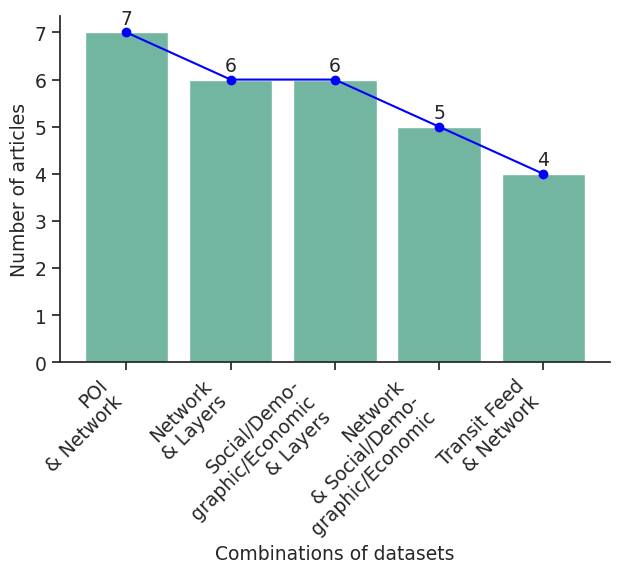

In [84]:
x, y = comb_df_mod["Combination"][:5], comb_df_mod["Number of articles"][:5]

ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45, ha="right")
xlabels = []
for text in list(x):
    if "\\" in text:
        splits = text.split("\\n")
        text = splits[0] + "\n" + splits[1]
    xlabels.append(f"{text}")
sns.barplot(x="Combination", y="Number of articles", data=comb_df_mod[:5]).set(
    ylabel="Number of articles", xlabel="Combinations of datasets"
)
plt.plot(x, y, "o-", color="blue")
plt.xticks(list(x), labels=xlabels)
for i, v in enumerate(y):
    plt.text(i, v + max(y) / 40, "%d" % v, ha="center")
sns.despine()

plt.savefig("img/comb_other_datasets.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Bar plots

In [85]:
# Plot some of the main information that can be easily illustrated with a bar plot

In [86]:
columns_to_plot = array_columns.copy()
columns_to_plot.remove("Features")
columns_to_plot.remove("Validation metrics")
columns_to_plot.remove("Supplementary datasets")
columns_to_plot.remove("Year(s)")
columns_to_plot.append("Study Area Country")
columns_to_plot.append("Journal ISO Abbreviation")
columns_to_plot.append("First country")
columns_to_plot.append("First affiliation")

In [87]:
# Change some terms for visualization
diccionario = dict({x: x for x in columns_to_plot})
diccionario['Author Full Names'] = 'Authors'
diccionario['Study Area Country'] = 'Countries'
diccionario['Algorithm'] = 'Algorithms'
diccionario['Algorithm type'] = 'Algorithm types'
diccionario['Journal ISO Abbreviation'] = 'Journals'
diccionario['First country'] = 'Countries'
diccionario['First affiliation'] = 'Affiliations'
diccionario['Supplementary datasets'] = 'Supplementary datasets'
diccionario['Analytical category']='Analytical purpose'

In [88]:
# Change some terms for visualization
plot_list = data[["ID",'First affiliation']].groupby(["ID",'First affiliation']).nunique().reset_index()['First affiliation'].value_counts().items()
plot_list = sorted(plot_list, key=itemgetter(1), reverse=True)
affiliations = dict(plot_list[:10])
for affiliation in affiliations.keys():
    if len(affiliation) > 18:
        splits = affiliation[::-1].split(maxsplit=1)
        affiliations[affiliation] = splits[1][::-1]+'\n'+splits[0][::-1]
        continue
    affiliations[affiliation]=affiliation
affiliations['Massachusetts Institute of Technology (MIT)'] = 'Massachusetts Institute\nof Technology (MIT)'
affiliations['RLUK- Research Libraries UK'] = 'RLUK - Research Libraries UK'
affiliations['Seoul National University (SNU)'] = 'Seoul National University (SNU)'

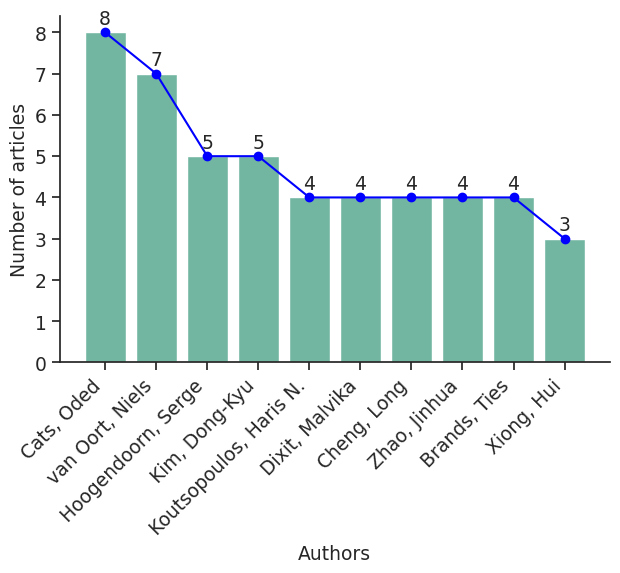

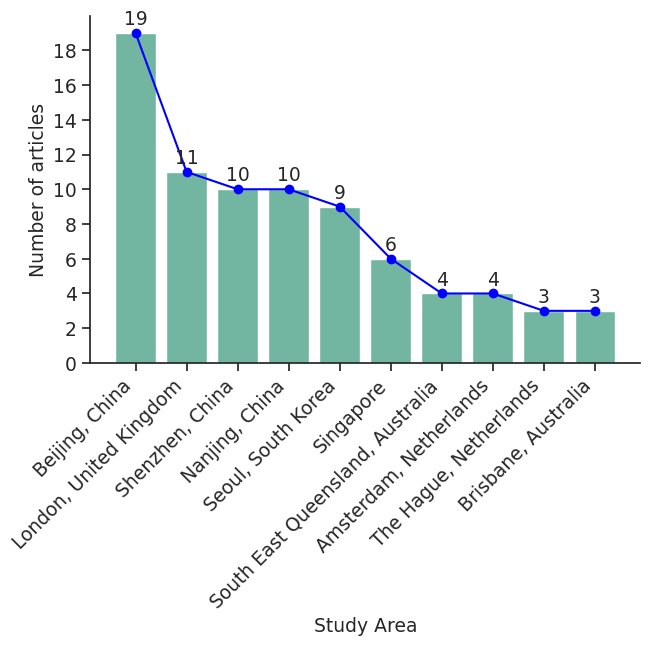

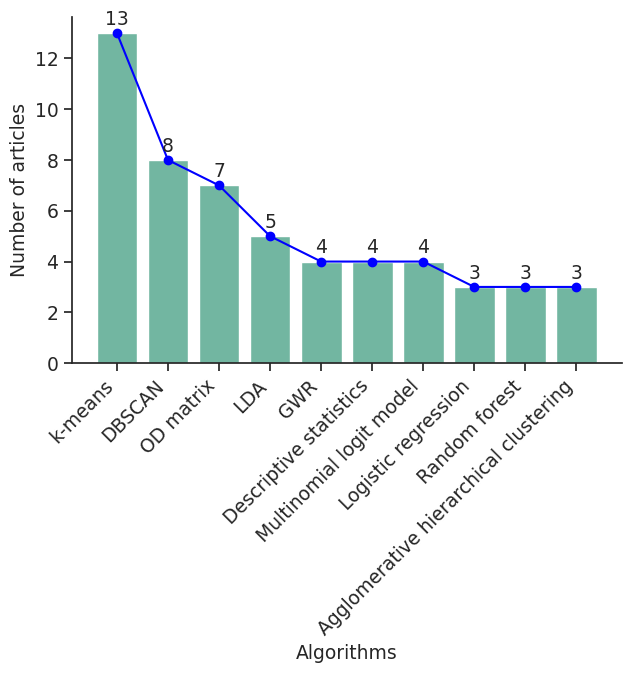

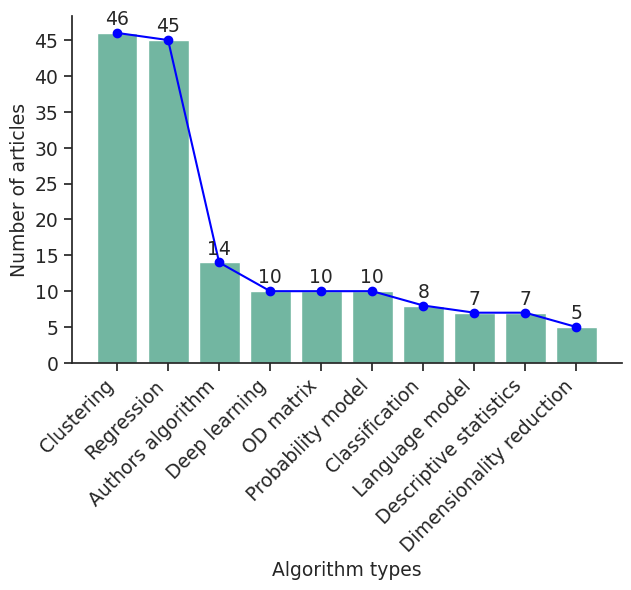

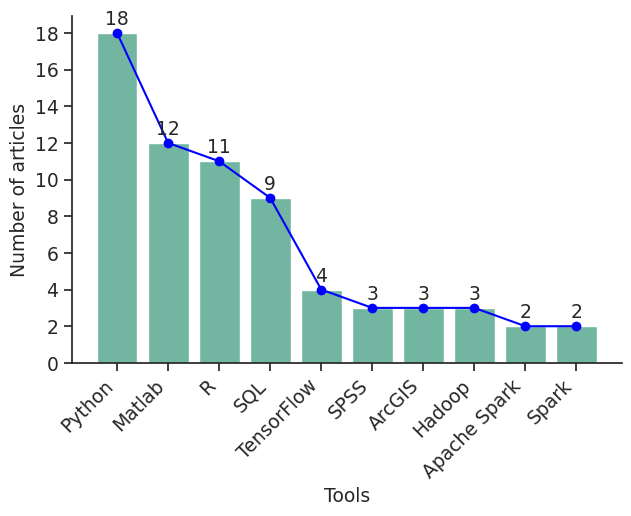

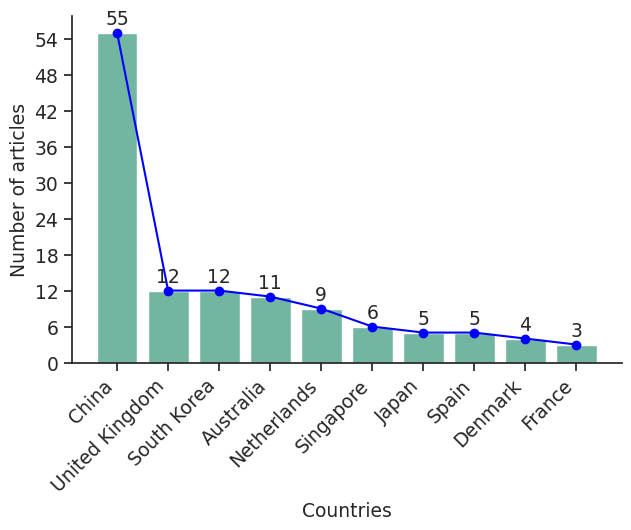

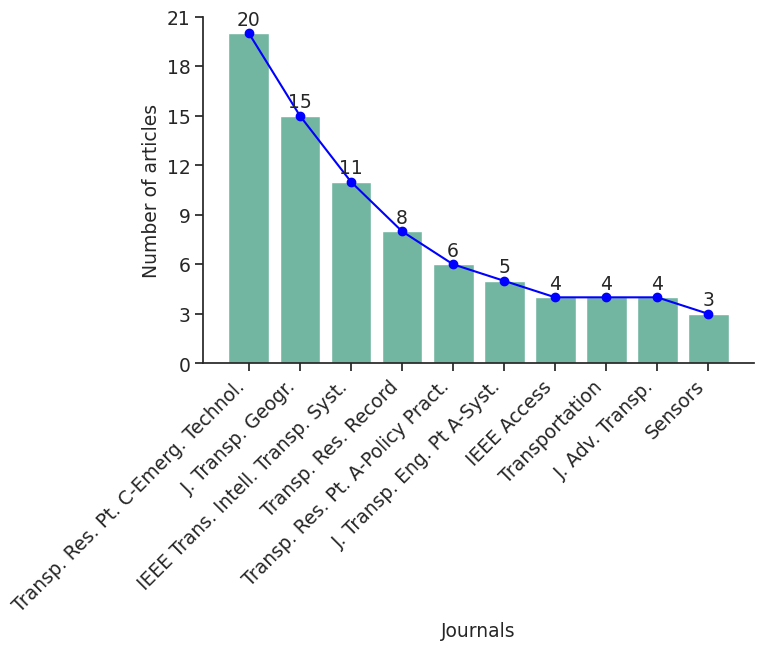

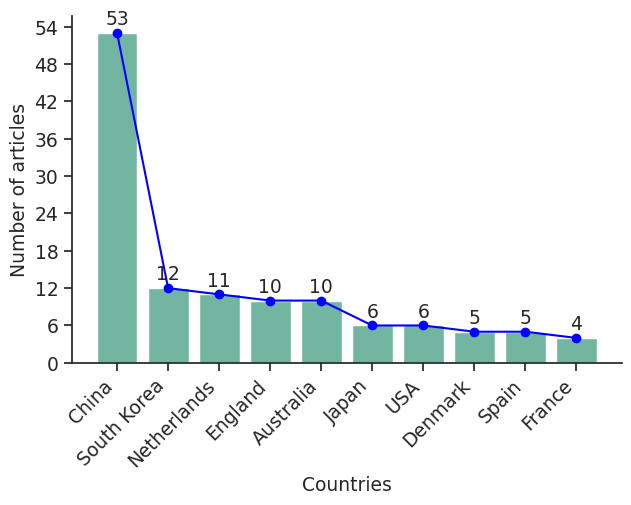

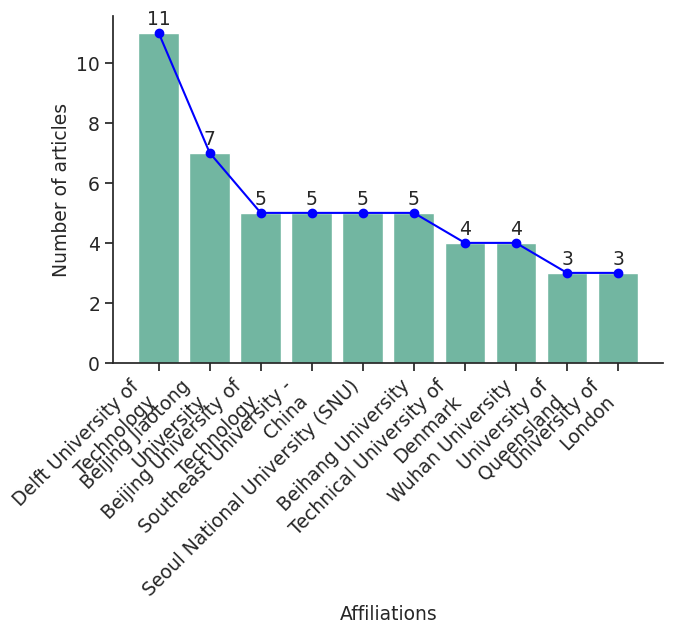

In [89]:
# Create simple bar plots

for column in columns_to_plot:
    plot_list = data[["ID",column]].groupby(["ID",column]).nunique().reset_index()[column].value_counts().items()
    plot_list = sorted(plot_list, key=itemgetter(1), reverse=True)
    x, y = zip(*plot_list[:10])
    ax = plt.figure().gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(rotation=45, ha="right")
 
    sns.barplot(x = 'x', y = 'y', data={'x': list(x), 'y': list(y)}).set(ylabel='Number of articles', xlabel=diccionario[column])
    plt.plot(x, y, "o-", color="blue")
    xlabels = []
    for text in list(x):
        if '\\' in str(text):
            splits = text.split('\\n')
            text = splits[0]+'\n'+splits[1]
        if column == 'First affiliation':
            text = affiliations[text]
        xlabels.append(f"{text}")
    plt.xticks(list(x),labels=xlabels)
    for i, v in enumerate(y):
        plt.text(i, v + max(y)/40, "%d" % v, ha="center")
    sns.despine()

    plt.savefig("img/bar_plot_" + str(column) + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()

### Treemap Analysis-Algorithm

In [90]:
sns.set(
    style="ticks",
    palette="Set2",
    rc={
        "figure.figsize": (7.1, 4.5),
        "axes.labelsize": 13.5,
        "font.size": 13.5,
        "legend.fontsize": 13.5,
        "xtick.labelsize": 13.5,
        "ytick.labelsize": 13.5,
        "text.usetex": False,
    },
)

aggregated_table = (
    data[columns]
    .groupby(["Analytical category", "Algorithm", "Algorithm type"])[["ID"]]
    .nunique()
    .groupby(["Analytical category", "Algorithm type"])[["ID"]]
    .sum()    
    .sort_values(by="ID")
)

aggregated_table2 = (
    data[columns]
    .groupby(["Analytical category", "Algorithm", "Algorithm type"])[["ID"]]
    .nunique()
    .groupby(["Analytical category", "Algorithm type"])[["ID"]]
    .sum()    
    .groupby(["Analytical category"])[['ID']]
    .sum()
    .sort_values(by="ID", ascending=False)
)

aggregated_table2['ID'] = px.colors.sample_colorscale(px.colors.sequential.YlGnBu_r, len(aggregated_table2['ID']))

fig = px.treemap(
    aggregated_table.reset_index(),
    path=["Analytical category", "Algorithm type"],
    values="ID",
    color='Analytical category',
    color_discrete_map=aggregated_table2.to_dict()['ID']
)
fig.update_traces(
    root_color="white", textinfo="label+value"
)
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0), height=570,width=800)
fig.write_image("img/treemap_analysis_algorithm.pdf")
fig.show()

## Group small categories into one

In [91]:
# Group small categories into a category called other for a better presentation and understanding of the data

In [92]:
aggregated_table = (
    data[columns]
    .groupby(["Analytical category"])[["ID"]]
    .nunique()
    .sort_values(by="ID")
)
threshold = aggregated_table.sum().item() * 0.025
other_analysis = aggregated_table.query("ID < @threshold").index.values

aggregated_table = (
    data[columns]
    .groupby(["Algorithm", "Algorithm type"])[["ID"]]
    .nunique()
    .groupby(["Algorithm type"])[["ID"]]
    .sum()
    .sort_values(by="ID")
)
threshold = aggregated_table.sum().item() * 0.025
other_algorithm = aggregated_table.query("ID < @threshold").index.values

aggregated_table = (
    data[columns]
    .groupby(["Supplementary datasets"])[["ID"]]
    .nunique()
    .sort_values(by="ID")
)
threshold = aggregated_table.sum().item() * 0.05
other_datasets = aggregated_table.query("ID < @threshold").index.values

aggregated_table = (
    data[columns].groupby(["Validation metrics"])[["ID"]].nunique().sort_values(by="ID")
)
threshold = aggregated_table.sum().item() * 0.025
other_validation = aggregated_table.query("ID < @threshold").index.values

data["Algorithm type"] = data["Algorithm type"].apply(
    lambda x: "Other" if x in other_algorithm else x
)

data["Analytical category"] = data["Analytical category"].apply(
    lambda x: "Other" if x in other_analysis else x
)
data.loc[data["Analytical category"] == "Other", "Analytical subcategory"] = "Other"
data.loc[data["Analytical category"] == "Other", "Analytical subcategory"]

data["Supplementary datasets"] = data["Supplementary datasets"].apply(
    lambda x: "Other" if x in other_datasets else x
)
# data["Validation metrics"] = data["Validation metrics"].apply(
#     lambda x: "Other" if x in other_validation else x
# )

## Extract possible clusters of smart cards

0.42255458524219824


/home/leo/VCodeProjects/Analisis_cleaned/.venv/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



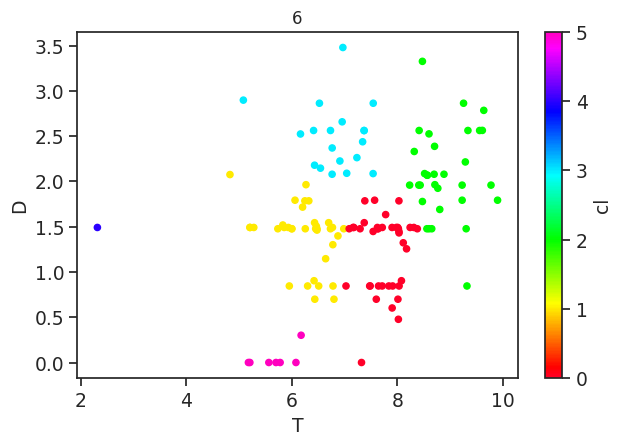

In [93]:
aggregated_table = data[["ID","Study Area","Total number transactions","Days"]].dropna().drop_duplicates().copy()
aggregated_table[["Total number transactions","Days"]] = aggregated_table[["Total number transactions","Days"]].astype("Float64")
plotTable=aggregated_table[["Total number transactions","Days"]].copy()
table = aggregated_table.copy()
plotTable["Total number transactions"] = plotTable["Total number transactions"].apply(lambda x: log(x,10))
plotTable["Days"] = plotTable["Days"].apply(lambda x: log(x,10))


scaler = StandardScaler()
aggregated_table[["Total number transactions","Days"]] = pd.DataFrame(scaler.fit_transform(aggregated_table[["Total number transactions","Days"]]))

clt = KMeans(n_clusters=6)
model = clt.fit(plotTable)
print(silhouette_score(plotTable,model.labels_))
plotTable["cl"] = model.labels_
plotTable.columns = ["T","D","cl"]
plotTable.plot.scatter("T","D",c="cl", colormap='gist_rainbow', title=str(6))
array = np.array([0,1,2,3,4,5,6,7,8,9,10])

aggregated_table["cl"] = model.labels_
table["cl"] = model.labels_
aggregated_table = aggregated_table.explode("Study Area")
aggregated_table = aggregated_table.groupby(["cl","Study Area"])[["ID"]].nunique()

# print(aggregated_table.reset_index().to_latex(index=False))


In [94]:
# Extract the possible groups manually
aggregated_table = data[["ID","Study Area","Total number transactions","Days", "Analytical category"]].dropna().drop_duplicates().copy()
aggregated_table[["Total number transactions","Days"]] = aggregated_table[["Total number transactions","Days"]].astype("Float64")
aggregated_table["Total number transactions"] = np.log10(aggregated_table["Total number transactions"])
table = aggregated_table[(aggregated_table["Total number transactions"]>=8.5)&(aggregated_table["Total number transactions"]<=10)&(aggregated_table["Days"]>=7)]
print(table.shape)
print(table.explode("Study Area").groupby("Study Area")[["ID"]].nunique().reset_index()["Study Area"].to_list())
print(table)
print(table["Analytical category"].value_counts()/table.shape[0])

(25, 5)
['Amsterdam, Netherlands', 'Beijing, China', 'Guangzhou, China', 'Hangzhou, China', 'Kansai Area, Japan', 'London, United Kingdom', 'Madrid, Spain', 'Seoul, South Korea', 'Shanghai, China', 'Shenzhen, China', 'Singapore', 'South Korea', 'Stockholm, Sweden', 'Taipei City, Taiwan']
       ID              Study Area  Total number transactions   Days  \
1    P070     Taipei City, Taiwan                   8.707449  244.0   
31   P138       Stockholm, Sweden                    8.60206  335.0   
32   P062          Beijing, China                    8.88616  120.0   
36   P071          Beijing, China                   9.291369  164.0   
39   P109        Guangzhou, China                   8.569374  117.0   
39   P109         Hangzhou, China                   8.569374  117.0   
45   P034           Madrid, Spain                    8.69897  120.0   
49   P118  London, United Kingdom                   8.806166   49.0   
65   P134         Shenzhen, China                   9.778151   91.0   
6

## More plots

In [95]:
# This time the plots have the others category.

### Stack Bar plots by years

In [96]:
columns_to_plot = ["Analytical category", "Algorithm type", "Supplementary datasets"]

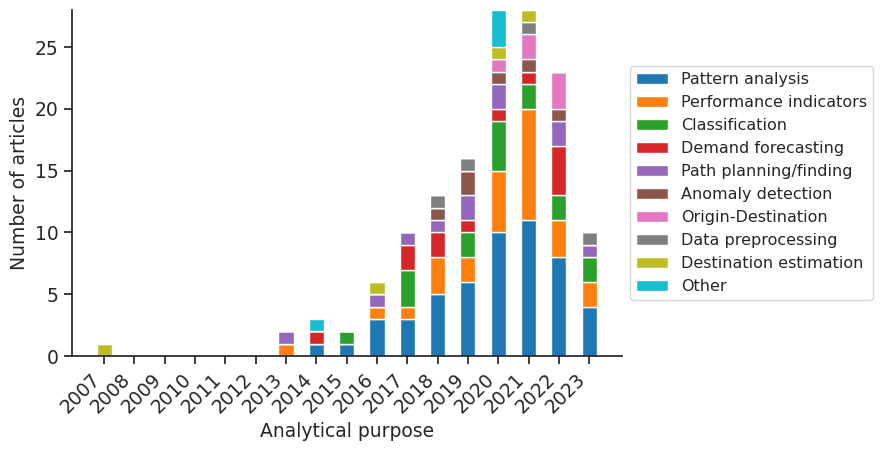

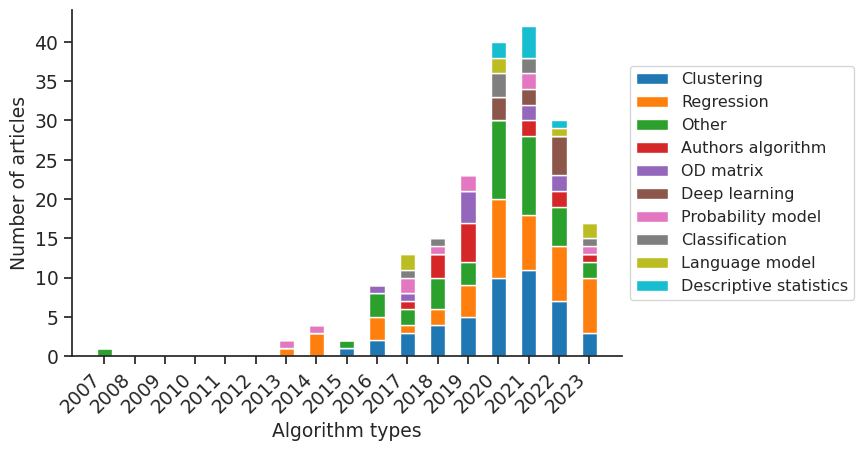

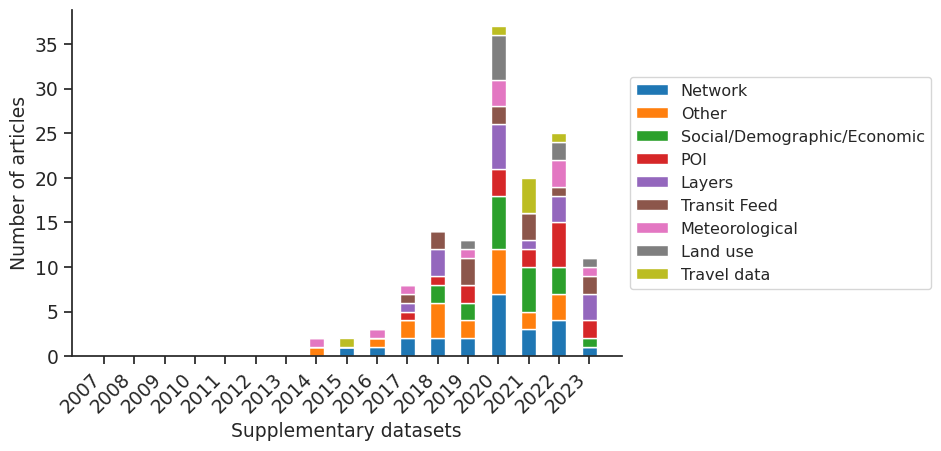

In [97]:
sns.set(
    style="ticks",
    palette="tab10",
    rc={
        "figure.figsize": (7.1, 4.5),
        "axes.labelsize": 13.5,
        "font.size": 13.5,
        "legend.fontsize": 11.5,
        "xtick.labelsize": 13.5,
        "ytick.labelsize": 13.5,
        "text.usetex": False,
    },
)

for column_to_plot in columns_to_plot:
    aggregated_table = (
        data[columns]
        .groupby([column_to_plot, "Publication Year"])[["ID"]]
        .nunique()
        .sort_values(by="ID")
    )
    x_array = (
        data[columns]
        .groupby([column_to_plot])[["ID"]]
        .nunique()
        .sort_values(by="ID", ascending=False)
        .index
    )
    years = sorted(list(set(data["Publication Year"])))
    weights_x = dict.fromkeys(x_array, 0)
    for x in weights_x.keys():
        weights_x[x] = []

    for x in x_array:
        for year in years:
            if (x, year) not in aggregated_table.index:
                weights_x[x].append(0)
                continue
            weights_x[x].append(aggregated_table.loc[(x, year)]["ID"])

    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    bottom = np.zeros(len(years))
    width = 0.5
    for x, weight_count in weights_x.items():
        p = ax.bar(
            list(map(int, years)), weight_count, width=width, label=x, bottom=bottom
        )
        bottom += weight_count

    # ax.set_title(column_to_plot + " vs Publication Year")
    ax.legend(loc="upper left")
    plt.xticks(range(2007, 2024), rotation=45, ha="right")
    plt.ylabel("Number of articles")
    plt.xlabel(diccionario[column_to_plot])
    ax.legend(bbox_to_anchor=(1, 0.5), loc="center left")
    sns.despine()
    plt.savefig(
        "img/stack_bar_plot_by_year" + str(column_to_plot) + ".pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.show()

#### Try with lines

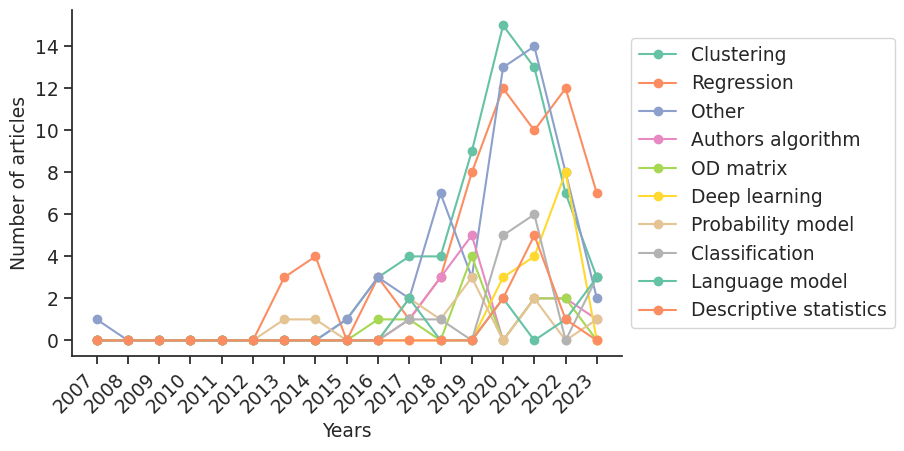

In [98]:
sns.set(
    style="ticks",
    palette="Set2",
    rc={
        "figure.figsize": (7.1, 4.5),
        "axes.labelsize": 13.5,
        "font.size": 13.5,
        "legend.fontsize": 13.5,
        "xtick.labelsize": 13.5,
        "ytick.labelsize": 13.5,
        "text.usetex": False,
    },
)

aggregated_table = (
    data[columns]
    .groupby(["Algorithm", "Algorithm type", "Publication Year"])[["ID"]]
    .nunique()
    .groupby(["Algorithm type", "Publication Year"])[["ID"]]
    .sum()
    .sort_values(by="ID")
)
x_array = (
    data[columns]
    .groupby(["Algorithm type"])[["ID"]]
    .nunique()
    .sort_values(by="ID", ascending=False)
    .index
)
hsv = plt.colormaps["hsv"].resampled(len(x_array))
col_map = plt.get_cmap("tab20", len(x_array))
years = range(2007,2024)
weights_x = dict.fromkeys(x_array, 0)
for x in weights_x.keys():
    weights_x[x] = [0] * len(years)

for x in x_array:
    for i, year in enumerate(years):
        if (x, year) not in aggregated_table.index:
            continue
        weights_x[x][i] += aggregated_table.loc[(x, year)]["ID"]

fig, ax = plt.subplots()
bottom = np.zeros(len(years))
width = 0.5
colors = hsv(range(len(x_array)))
for x, weight_count in weights_x.items():
    p = ax.plot(list(map(int, years)), weight_count, "o-", label=x)

ax.set_title("")
ax.legend(loc="upper left")
plt.xticks(range(2007,2024),rotation=45, ha="right")
plt.xlabel('Years')
plt.ylabel('Number of articles')
ax.legend(bbox_to_anchor=(1, 0.5),loc="center left")
sns.despine()
plt.savefig("img/line_algorithm_type" + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

### Treemaps

In [99]:
aggregated_table = (
    data[columns]
    .groupby(["Analytical category", "Validation metrics"])[["ID"]]
    .nunique()
    .sort_values(by="ID")
)

aggregated_table2 = (
    data[columns]
    .groupby(["Analytical category", "Validation metrics"])[["ID"]]
    .nunique()
    .groupby(["Analytical category"])[['ID']]
    .sum()
    .sort_values(by="ID", ascending=False)
)

aggregated_table2['ID'] = px.colors.sample_colorscale(px.colors.sequential.YlGnBu_r, len(aggregated_table2['ID']))

fig = px.treemap(
    aggregated_table.reset_index(),
    path=["Analytical category", "Validation metrics"],
    values="ID",
    color='Analytical category',
    color_discrete_map=aggregated_table2.to_dict()['ID']
)
fig.update_traces(
    root_color="white",
    textinfo="label+value"
)
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.write_image("img/treemap_analysys_validation.pdf")
fig.show()


In [100]:
aggregated_table = (
    data[columns]
    .groupby(["Algorithm", "Algorithm type", "Validation metrics"])[["ID"]]
    .nunique()
    .groupby(["Algorithm type", "Validation metrics"])[["ID"]]
    .sum()
    .sort_values(by="ID")
)

aggregated_table2 = (
    data[columns]
    .groupby(["Algorithm", "Algorithm type", "Validation metrics"])[["ID"]]
    .nunique()
    .groupby(["Algorithm type", "Validation metrics"])[["ID"]]
    .sum()
    .groupby(["Algorithm type"])[['ID']]
    .sum()
    .sort_values(by="ID", ascending=False)
)

aggregated_table2['ID'] = px.colors.sample_colorscale(px.colors.sequential.YlGnBu_r, len(aggregated_table2['ID']))

fig = px.treemap(
    aggregated_table.reset_index(),
    path=["Algorithm type", "Validation metrics"],
    values="ID",
    color='Algorithm type',
    color_discrete_map=aggregated_table2.to_dict()['ID']
)
fig.update_traces(
    root_color="white", textinfo="label+value"
)
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.write_image("img/treemap_algorithm_type_validation.pdf")
fig.show()

### World maps

#### Articles by country of the study area

In [101]:
df = px.data.gapminder().query("year==2007")
df = df[["country", "iso_alpha"]]
countries_count = dict(data[["ID","Study Area Country"]].groupby("Study Area Country")["ID"].nunique())
study_country = pd.DataFrame(columns=["country", "iso_alpha", "Number of articles"])
for country in data["Study Area Country"].unique():
    if len(df.query("country == @country")["iso_alpha"].values) != 0:
        study_country = pd.concat(
            [
                study_country,
                pd.Series(
                    {
                        "country": country,
                        "iso_alpha": df.query("country == @country")["iso_alpha"].values[0],
                        "Number of articles": countries_count[country],
                    }
                ).to_frame().T,
            ],
            ignore_index=True,
        )

study_country["Number of articles"] = pd.to_numeric(study_country["Number of articles"])
incorrect_study_country = pd.DataFrame(
    [
        {
            "country": "Latvia",
            "iso_alpha": "LVA",
            "Number of articles": countries_count["Latvia"],
        },
        {
            "country": "United States of America",
            "iso_alpha": "USA",
            "Number of articles": countries_count["United States of America"],
        },
        {
            "country": "South Korea",
            "iso_alpha": "KOR",
            "Number of articles": countries_count["South Korea"],
        },
    ]
)
study_country = pd.concat([study_country, incorrect_study_country], ignore_index=True)

fig = px.choropleth(
    study_country,
    locations="iso_alpha",
    color="Number of articles",  # lifeExp is a column of gapminder
    hover_name="country",  # column to add to hover information
    color_continuous_scale=px.colors.sequential.Plasma_r,
)
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.write_image("img/study_map.pdf")
fig.show()

#### Articles by the country of the first author

In [102]:
df = px.data.gapminder().query("year==2007")
df = df[["country", "iso_alpha"]]
countries_count = dict(data[["ID","First country"]].groupby("First country")["ID"].nunique())
study_country = pd.DataFrame(columns=["country", "iso_alpha", "Number of articles"])
for country in data["First country"].unique():
    if len(df.query("country == @country")["iso_alpha"].values) != 0:
        study_country = pd.concat(
            [
                study_country,
                pd.Series(
                    {
                        "country": country,
                        "iso_alpha": df.query("country == @country")["iso_alpha"].values[0],
                        "Number of articles": countries_count[country],
                    }
                ).to_frame().T,
            ],
            ignore_index=True,
        )

study_country["Number of articles"] = pd.to_numeric(study_country["Number of articles"])
incorrect_study_country = pd.DataFrame(
    [
        {
            "country": "Latvia",
            "iso_alpha": "LVA",
            "Number of articles": countries_count["Latvia"],
        },
        {
            "country": "United States of America",
            "iso_alpha": "USA",
            "Number of articles": countries_count["USA"],
        },
        {
            "country": "South Korea",
            "iso_alpha": "KOR",
            "Number of articles": countries_count["South Korea"],
        },
        {
            "country": "China",
            "iso_alpha": "CHN",
            "Number of articles": countries_count["China"],
        },
        {
            "country": "United Kingdom",
            "iso_alpha": "GBR",
            "Number of articles": countries_count["England"],
        },
    ]
)
study_country = pd.concat([study_country, incorrect_study_country], ignore_index=True)
fig = px.choropleth(
    study_country,
    locations="iso_alpha",
    color="Number of articles",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.Plasma_r,
)
fig.write_image("img/authors_map.pdf")
fig.show()

In [103]:
biblio.columns = [column.replace(" ", "_") for column in biblio.columns]

#### Number of papers of affiliations of the first author

In [104]:
df = px.data.gapminder().query("year==2007")
lat = []
lon = []
affiliations = []
values = []
affiliations_count = dict(data[["ID","First affiliation"]].groupby("First affiliation")["ID"].nunique())
for affiliation in data["First affiliation"].unique():
    affiliations.append(affiliation)
    lat.append(biblio.query("First_affiliation == @affiliation")["First_affiliation_coordinates"].values[0][0])
    lon.append(biblio.query("First_affiliation == @affiliation")["First_affiliation_coordinates"].values[0][1])
    values.append(affiliations_count[affiliation])

df = pd.DataFrame({"affiliation":affiliations,
                  "lat":lat,
                  "lon":lon,
                  "values":values})
fig = px.scatter_geo(df, lat="lat", lon="lon",
                     hover_name="affiliation", size="values",
                     projection="natural earth", color="values")
fig.write_image("img/affiliation_map.pdf")
fig.show()

#### Articles by study area

In [105]:
df = px.data.gapminder().query("year==2007")
lat = []
lon = []
cities = []
values = []
cities_count = dict(data[["ID","Study Area"]].groupby("Study Area")["ID"].nunique())
for city in data["Study Area"].unique():
    cities.append(city)
    if city == "South-West Scania, Sweden":
        coordinates = ox.geocode("Scania, Sweden")
    elif city == "Greater Toronto and Hamilton Area, Canada":
        coordinates = ox.geocode("Toronto, Canada")
    elif city == "Kansai Area, Japan":
        coordinates = ox.geocode("関西地方")
    elif city == "Greater Copenhagen area, Denmark":
        coordinates = ox.geocode("Copenhague, Denmark")
    elif city == "Eastern Denmark, Denmark":
        coordinates = ox.geocode("Denmark")
    else:
        coordinates = ox.geocode(city)
    lat.append(coordinates[0])
    lon.append(coordinates[1])
    values.append(cities_count[city])

df = pd.DataFrame({"cities":cities,
                  "lat":lat,
                  "lon":lon,
                  "values":values})
fig = px.scatter_geo(df, lat="lat", lon="lon",
                     hover_name="cities", size="values",
                     projection="natural earth", color="values")
fig.write_image("img/study_area_map.pdf")
fig.show()

#### Articles by study area with Basemap

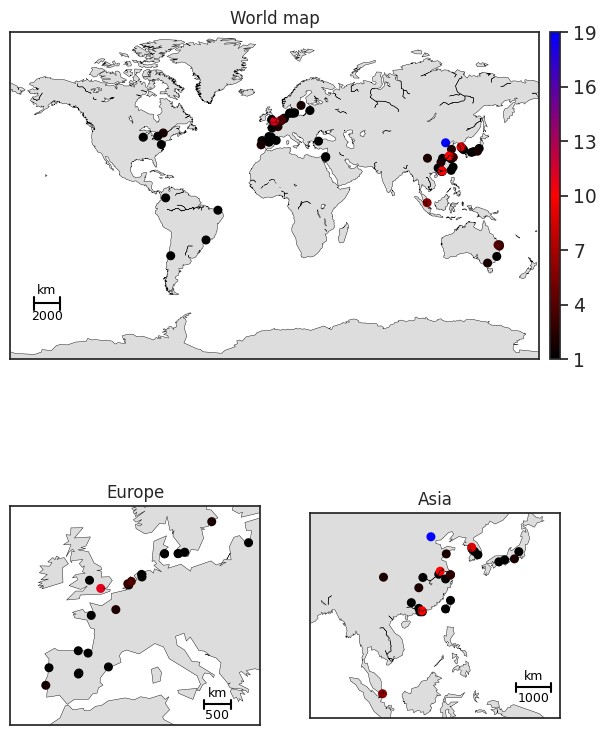

In [106]:
sns.set(
    style="ticks",
    palette="Set2",
    rc={
        "figure.figsize": (7.1, 10),
        "axes.labelsize": 13.5,
        "font.size": 13.5,
        "legend.fontsize": 13.5,
        "xtick.labelsize": 13.5,
        "ytick.labelsize": 13.5,
        "text.usetex": False,
    },
)

cmap = LinearSegmentedColormap.from_list('name', ['black', 'red', 'blue'])

# World map
df.sort_values(by='values', inplace=True)
plt.subplot(211)
map_plot = Basemap(projection='mill',llcrnrlon=-180.,llcrnrlat=-80.,urcrnrlon=180.,urcrnrlat=85.)
map_plot.fillcontinents(color="#DDDDDD")
map_plot.drawcoastlines(linewidth=0.3)
map_plot.drawmapscale(lon=-155, lat=-59, lon0=0,lat0=0, length=2000)
x,y=map_plot(df["lon"].to_list(), df["lat"].to_list())
map_plot.scatter(x,y, s=30, marker='o',c=df["values"], cmap=cmap)
map_plot.colorbar(size='2%', ticks=range(min(df["values"]),max(df["values"])+1,3))
plt.title("World map")

# Europe
plt.subplot(223)
map_plot = Basemap(projection='mill',llcrnrlon=-15.,llcrnrlat=33.,urcrnrlon=26.,urcrnrlat=61.)
map_plot.fillcontinents(color="#DDDDDD")
map_plot.drawcoastlines(linewidth=0.3)
map_plot.drawmapscale(lon=19, lat=36, lon0=0,lat0=0, length=500)
x,y=map_plot(df["lon"].to_list(), df["lat"].to_list())
map_plot.scatter(x,y, s=30, marker='o',c=df["values"], cmap=cmap)
plt.title("Europe")

# Asia
plt.subplot(224)
map_plot = Basemap(projection='mill',llcrnrlon=85.,llcrnrlat=-5.,urcrnrlon=150.,urcrnrlat=45.)
map_plot.fillcontinents(color="#DDDDDD")
map_plot.drawcoastlines(linewidth=0.3)
map_plot.drawmapscale(lon=143, lat=3, lon0=0,lat0=0, length=1000)
x,y=map_plot(df["lon"].to_list(), df["lat"].to_list())
map_plot.scatter(x,y, s=30, marker='o',c=df["values"], cmap=cmap)
plt.title("Asia")
plt.savefig("img/study_area_map.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Other plots

#### Number of articles by years

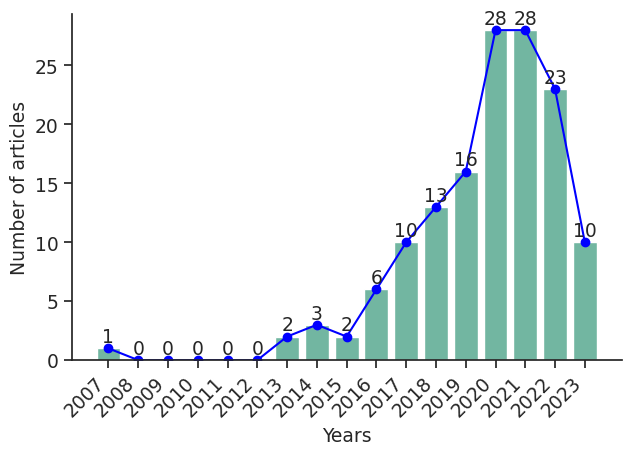

In [107]:
sns.set(
    style="ticks",
    palette="Set2",
    rc={
        "figure.figsize": (7.1, 4.5),
        "axes.labelsize": 13.5,
        "font.size": 13.5,
        "legend.fontsize": 13.5,
        "xtick.labelsize": 13.5,
        "ytick.labelsize": 13.5,
        "text.usetex": False,
    },
)

aggregated_table = (
    data[columns]
    .groupby(["Publication Year"])[["ID"]]
    .nunique()
    .sort_values(by="Publication Year")
).reset_index().copy()

for i in range(aggregated_table["Publication Year"].min(), aggregated_table["Publication Year"].max() + 1):
    if i not in aggregated_table["Publication Year"].values:
        aggregated_table.loc[len(aggregated_table)] = [i, 0]
aggregated_table.sort_values(by="Publication Year", inplace=True)

x = list(map(str, aggregated_table["Publication Year"]))
y = list(aggregated_table["ID"])

plt.xticks(rotation=45, ha="right")
sns.barplot(x = 'x', y = 'y', data={'x': list(x), 'y': list(y)}).set(ylabel='Number of articles', xlabel='Years')
plt.plot(x, y, "o-", color="blue")
for i, v in enumerate(y):
    plt.text(i, v + 0.5, "%d" % v, ha="center")
sns.despine()
plt.savefig("img/bar_plot_" + "Years" + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Number of articles by country and year

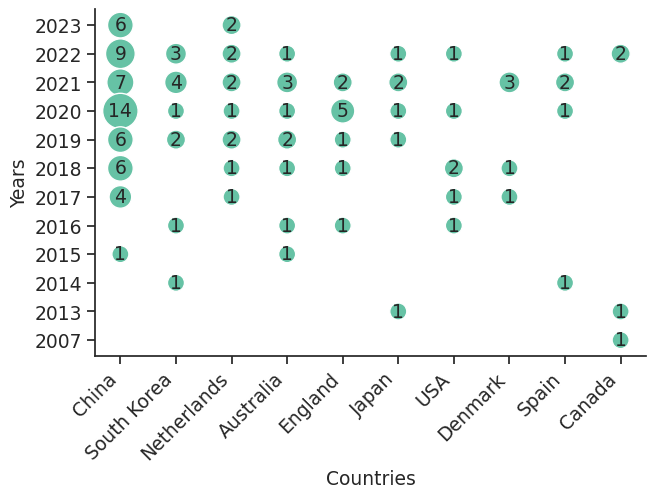

In [108]:
sns.set(
    style="ticks",
    palette="Set2",
    rc={
        "figure.figsize": (7.1, 4.5),
        "axes.labelsize": 13.5,
        "font.size": 13.5,
        "legend.fontsize": 13.5,
        "xtick.labelsize": 13.5,
        "ytick.labelsize": 13.5,
        "text.usetex": False,
    },
)


countries_count = dict(data[["ID","First country"]].groupby("First country")["ID"].nunique())

plot_list = countries_count.items()
plot_list = sorted(plot_list, key=itemgetter(1), reverse=True)
x, y = zip(*plot_list)

aggregated_table = (
    data[columns]
    .groupby(["Publication Year","First country"])[["ID"]]
    .nunique()
    .sort_values(by="Publication Year")
).reset_index()

aggregated_table["First country"]=pd.Categorical(aggregated_table["First country"], x, ordered=True)

aggregated_table = aggregated_table.sort_values(by=["Publication Year","First country"], ascending=False)
aggregated_table = aggregated_table[aggregated_table["First country"].isin(x[:10])]

s = aggregated_table["ID"]
aggregated_table["Publication Year"] = list(map(str,aggregated_table["Publication Year"]))
x = aggregated_table["First country"]

plt.xticks(rotation=45, ha="right")
sns.scatterplot(data = aggregated_table, x="First country", y="Publication Year", size="ID", sizes=(150, 650), legend = False).set(ylabel='Years', xlabel = 'Countries')
sns.despine()
for i, v, s in aggregated_table.values.tolist():
     if s!=0:
        plt.text(v, str(i), "%d" % s, ha="center", va="center")
plt.savefig("img/" + "Contry_by_Years" + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Years elapsed between dataset collection and use

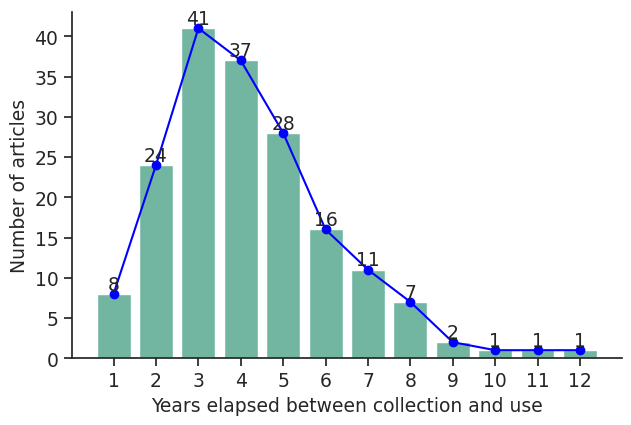

In [109]:
sns.set(
    style="ticks",
    palette="Set2",
    rc={
        "figure.figsize": (7.1, 4.5),
        "axes.labelsize": 13.5,
        "font.size": 13.5,
        "legend.fontsize": 13.5,
        "xtick.labelsize": 13.5,
        "ytick.labelsize": 13.5,
        "text.usetex": False,
    },
)


aggregated_table = (
    data[columns]
    .groupby(["Publication Year","Year(s)"])[["ID"]]
    .nunique()
    .sort_values(by=["Publication Year", "Year(s)"])
).reset_index()
aggregated_table["diff"] = aggregated_table["Publication Year"] - aggregated_table["Year(s)"]
aggregated_table = (
    aggregated_table
    .groupby(["diff"])[["ID"]]
    .sum()
    .sort_values(by=["diff"])
).reset_index()
# aggregated_table = aggregated_table[aggregated_table["First country"].isin(x[:10])]

y = aggregated_table["ID"]
x = list(map(str, aggregated_table["diff"]))


# plt.figure(figsize=(10, 8))
sns.barplot(x = 'x', y = 'y', data={'x': list(x), 'y': list(y)}).set(ylabel='Number of articles', xlabel='Years elapsed between collection and use')
plt.plot(x, y, "o-", color="blue")
for i, v in enumerate(y):
    plt.text(i, v + 0.5, "%d" % v, ha="center")
sns.despine()
# plt.subplots_adjust(bottom=0.28)
plt.savefig("img/bar_plot_" + "diff_pub_data_Years" + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Sunburst plot of analytical purpose categories and subcategories

In [110]:
columns.append("DOI")

In [111]:
columns.append("Analytical subcategory")

In [112]:
aggregated_table = (
    data[columns]
    .groupby(["Analytical category", "Analytical subcategory"])[["ID"]]
    .nunique()
    .sort_values(by=['Analytical category', 'Analytical subcategory', 'ID'], ascending=True)
).reset_index()

aggregated_table2 = (
    data[columns]
    .groupby(["Analytical category"])[["ID"]]
    .nunique()
    .sort_values(by=['ID'], ascending=False)
).reset_index()

aggregated_table2['ID'] = px.colors.sample_colorscale(px.colors.sequential.YlGnBu_r, 10)
aggregated_table2.set_index('Analytical category', inplace=True)

fig = px.sunburst(
    aggregated_table.reset_index(),
    path=["Analytical category", "Analytical subcategory"],
    values="ID",
    color='Analytical category',
    color_discrete_map=aggregated_table2.to_dict()['ID']
)
fig.update_traces(
textinfo="label+value",
root_color='white',
insidetextorientation='radial'
)
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.write_image("img/treemap_analysys_categories.pdf", width=500, height=500)
fig.show()

## Extract Latex tables

### Analysis category-Algorithm type table

In [113]:
aggregated_table = (
    data[columns]
    .groupby(["Analytical category", "Algorithm", "Algorithm type", "DOI"])[["ID"]]
    .nunique()
    .groupby(["Analytical category", "Algorithm type", "DOI"])[["ID"]]
    .sum()
    .sort_values(by="ID")
).reset_index()
aggregated_table["DOI"] = aggregated_table["DOI"].apply(lambda x: "\cite{" + x + "} ")
aggregated_table = aggregated_table.groupby(["Analytical category", "Algorithm type"])[["DOI"]].sum().reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{lll}
\toprule
Analytical category & Algorithm type & DOI \\
\midrule
Anomaly detection & Authors algorithm & \cite{10.1109/TKDE.2018.2834909}  \\
Anomaly detection & Clustering & \cite{10.1109/TITS.2020.3032843} \cite{10.1109/TKDE.2018.2834909} \cite{10.1109/TITS.2020.2983853} \cite{10.1109/TITS.2019.2933497}  \\
Anomaly detection & Deep learning & \cite{10.1109/TITS.2020.3032843}  \\
Anomaly detection & OD matrix & \cite{10.1109/ACCESS.2019.2943598} \cite{10.1109/TITS.2020.2983853}  \\
Anomaly detection & Other & \cite{10.1016/j.neucom.2017.12.067}  \\
Classification & Classification & \cite{10.1016/j.trc.2017.03.021}  \\
Classification & Clustering & \cite{10.1016/j.scs.2021.103027} \cite{10.1007/s12469-016-0145-8} \cite{10.1016/j.cities.2022.103773} \cite{10.1016/j.iatssr.2019.09.001} \cite{10.1016/j.jtrangeo.2020.102820} \cite{10.1016/j.jtrangeo.2022.103459} \cite{10.1016/j.trc.2015.03.033} \cite{10.1061/JTEPBS.TEENG-7634} \cite{10.18494/SAM.2019.2589} \cite{10.3390

### Analysis category and subcategory - Algorithm type table

In [114]:
aggregated_table = (
    data[columns]
    .groupby(["Analytical category", "Analytical subcategory", "Algorithm", "Algorithm type", "DOI"])[["ID"]]
    .nunique()
    .groupby(["Analytical category", "Analytical subcategory", "Algorithm type", "DOI"])[["ID"]]
    .sum()
    .sort_values(by="ID")
).reset_index()
aggregated_table["DOI"] = aggregated_table["DOI"].apply(lambda x: [x])
aggregated_table = aggregated_table.groupby(["Analytical category", "Analytical subcategory", "Algorithm type"])[["DOI"]].sum().reset_index()
aggregated_table["DOI"] = aggregated_table["DOI"].apply(lambda x: "\cite{" + ', '.join(x) + '}')
print(aggregated_table.to_latex(index=False))

\begin{tabular}{llll}
\toprule
Analytical category & Analytical subcategory & Algorithm type & DOI \\
\midrule
Anomaly detection & Passengers behaviour & Authors algorithm & \cite{10.1109/TKDE.2018.2834909} \\
Anomaly detection & Passengers behaviour & Clustering & \cite{10.1109/TITS.2020.3032843, 10.1109/TKDE.2018.2834909, 10.1109/TITS.2020.2983853, 10.1109/TITS.2019.2933497} \\
Anomaly detection & Passengers behaviour & Deep learning & \cite{10.1109/TITS.2020.3032843} \\
Anomaly detection & Passengers behaviour & OD matrix & \cite{10.1109/ACCESS.2019.2943598, 10.1109/TITS.2020.2983853} \\
Anomaly detection & Service disruptions/incidents & Other & \cite{10.1016/j.neucom.2017.12.067} \\
Classification & Social/Economic/Demographic & Clustering & \cite{10.1016/j.jtrangeo.2020.102820, 10.1016/j.scs.2021.103027, 10.1061/JTEPBS.TEENG-7634, 10.3390/s21093039} \\
Classification & Social/Economic/Demographic & Deep learning & \cite{10.1109/TITS.2019.2896460} \\
Classification & Social/Econom

### Total number transaction table

In [115]:
aggregated_table = (
    data[columns]
    .groupby(["log Total number transactions"])[["ID"]]
    .nunique()
    .sort_values(by="log Total number transactions")
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{lr}
\toprule
log Total number transactions & ID \\
\midrule
(2, 3] & 1 \\
(4, 5] & 1 \\
(5, 6] & 14 \\
(6, 7] & 38 \\
(7, 8] & 32 \\
(8, 9] & 33 \\
(9, 10] & 12 \\
NA & 11 \\
\bottomrule
\end{tabular}



### Time span table

In [116]:
aggregated_table = (
    data[columns]
    .groupby(["Days"])[["ID"]]
    .nunique()
    .sort_values(by="Days")
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{rr}
\toprule
Days & ID \\
\midrule
1.000000 & 8 \\
2.000000 & 1 \\
3.000000 & 1 \\
4.000000 & 2 \\
5.000000 & 4 \\
7.000000 & 13 \\
8.000000 & 2 \\
14.000000 & 2 \\
18.000000 & 1 \\
20.000000 & 1 \\
21.000000 & 1 \\
25.000000 & 2 \\
27.000000 & 1 \\
28.000000 & 2 \\
29.000000 & 1 \\
30.000000 & 18 \\
31.000000 & 15 \\
32.000000 & 1 \\
33.000000 & 1 \\
35.000000 & 3 \\
43.000000 & 1 \\
49.000000 & 1 \\
52.000000 & 1 \\
60.000000 & 2 \\
61.000000 & 4 \\
62.000000 & 4 \\
73.000000 & 1 \\
84.000000 & 1 \\
91.000000 & 5 \\
92.000000 & 2 \\
105.000000 & 1 \\
117.000000 & 1 \\
119.000000 & 1 \\
120.000000 & 3 \\
122.000000 & 2 \\
123.000000 & 1 \\
140.000000 & 1 \\
151.000000 & 1 \\
164.000000 & 1 \\
168.000000 & 1 \\
181.000000 & 1 \\
183.000000 & 1 \\
214.000000 & 1 \\
234.000000 & 1 \\
244.000000 & 1 \\
270.000000 & 1 \\
274.000000 & 1 \\
315.000000 & 1 \\
334.000000 & 1 \\
335.000000 & 1 \\
364.000000 & 1 \\
365.000000 & 6 \\
366.000000 & 1 \\
455.000000 & 1 \\
609.000000 

### Recopilation year table

In [117]:
aggregated_table = (
    data[columns]
    .groupby(["Year(s)"], dropna=False)[["ID"]]
    .nunique()
    .sort_values(by="Year(s)")
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{rr}
\toprule
Year(s) & ID \\
\midrule
2003 & 1 \\
2005 & 1 \\
2006 & 1 \\
2007 & 1 \\
2008 & 2 \\
2009 & 1 \\
2010 & 4 \\
2011 & 6 \\
2012 & 10 \\
2013 & 21 \\
2014 & 12 \\
2015 & 24 \\
2016 & 15 \\
2017 & 28 \\
2018 & 24 \\
2019 & 19 \\
2020 & 7 \\
NaN & 6 \\
\bottomrule
\end{tabular}



## Multimodal and Transport mode

In [118]:
aggregated_table = (
    data[['ID','Structure']]
    .groupby(["Structure"], dropna=False)[["ID"]]
    .nunique()
    .sort_values(by="Structure")
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Structure & ID \\
\midrule
Closed & 95 \\
Open & 25 \\
Open-Closed & 21 \\
NaN & 1 \\
\bottomrule
\end{tabular}



In [119]:
aggregated_table = (
    data[['ID','Transport mode','Structure']]
    .groupby(["Transport mode",'Structure'], dropna=False)[["ID"]]
    .nunique()
    .sort_values(by="ID", ascending=False)
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{llr}
\toprule
Transport mode & Structure & ID \\
\midrule
Multimodal & Closed & 42 \\
Subway & Closed & 26 \\
Multimodal & Open-Closed & 21 \\
Bus & Open & 20 \\
Bus & Closed & 15 \\
Train & Closed & 9 \\
Multimodal & Open & 5 \\
Bike & Closed & 3 \\
Bus & NaN & 1 \\
\bottomrule
\end{tabular}



In [120]:
data['Multimodal components number'] = data['Multimodal components'].apply(lambda x: len(x))

In [121]:
aggregated_table = (
    data[['ID','Multimodal components number']]
    .groupby(['Multimodal components number'], dropna=False)[["ID"]]
    .nunique()
    .sort_values(by='Multimodal components number')
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{rr}
\toprule
Multimodal components number & ID \\
\midrule
0 & 74 \\
2 & 44 \\
3 & 18 \\
4 & 4 \\
5 & 2 \\
\bottomrule
\end{tabular}



In [122]:
data['Multimodal components sorted'] = data['Multimodal components'].apply(lambda x: ', '.join(sorted(x)))


In [123]:
aggregated_table = (
    data[['ID','Multimodal components sorted']]
    .groupby(['Multimodal components sorted'], dropna=False)[["ID"]]
    .nunique()
    .sort_values(by='ID', ascending=False)
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Multimodal components sorted & ID \\
\midrule
 & 74 \\
Bus, Subway & 31 \\
Bus, Subway, Tram & 6 \\
Bus, Ferry, Train & 5 \\
Bus, Tram & 5 \\
Bus, Train & 4 \\
Bus, Subway, Train & 4 \\
Bus, Subway, Train, Tram & 3 \\
Bike, Subway & 2 \\
Bus, Ferry, Subway, Train, Tram & 2 \\
Bus, Ferry & 1 \\
Bus, Ferry, Train, Tram & 1 \\
Bus, Subway, Taxi & 1 \\
Bus, Train, Tram & 1 \\
Subway, Train, Tram & 1 \\
Subway, Tram & 1 \\
\bottomrule
\end{tabular}



### Multimodal components plot

In [124]:
data = data.explode('Multimodal components')

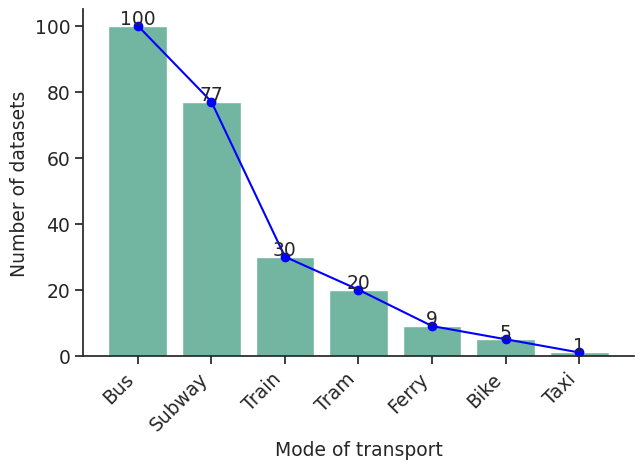

In [125]:
sns.set(
    style="ticks",
    palette="Set2",
    rc={
        "figure.figsize": (7.1, 4.5),
        "axes.labelsize": 13.5,
        "font.size": 13.5,
        "legend.fontsize": 13.5,
        "xtick.labelsize": 13.5,
        "ytick.labelsize": 13.5,
        "text.usetex": False,
    },
)


aggregated_table = (
    data[['ID','Transport mode','Multimodal components']]
    .groupby(['Transport mode','Multimodal components'], dropna=False)[["ID"]]
    .nunique()
    .sort_values(by='ID', ascending=False)
).reset_index()
aggregated_table.loc[aggregated_table['Transport mode']=='Multimodal',['Transport mode']] = aggregated_table[aggregated_table['Transport mode']=='Multimodal']['Multimodal components']

aggregated_table2 = (
    aggregated_table[['Transport mode','ID']]
    .groupby(['Transport mode'], dropna=False)[["ID"]]
    .sum()
    .sort_values(by='ID', ascending=False)
).reset_index()

plt.xticks(rotation=45, ha="right")
sns.barplot(x = 'Transport mode', y = 'ID', data=aggregated_table2).set(ylabel='Number of datasets', xlabel='Mode of transport')
plt.plot(aggregated_table2['Transport mode'], aggregated_table2['ID'], "o-", color="blue")
for i, v in enumerate(aggregated_table2['ID']):
    plt.text(i, v + 0.5, "%d" % v, ha="center")
sns.despine()
# plt.subplots_adjust(bottom=0.20)
plt.savefig("img/bar_plot_" + "Transport modes" + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

In [126]:
columns.append('Multimodal components')

In [127]:
columns.append('Transport mode')

In [128]:
aggregated_table = (
    data[columns]
    .groupby(['Multimodal components'])[["ID"]]
    .nunique()
    .sort_values(by='Multimodal components', ascending=False)
).reset_index()
aggregated_table

,Multimodal components,ID
0,Tram,20
1,Train,21
2,Taxi,1
3,Subway,51
4,Ferry,9
5,Bus,64
6,Bike,2
